### Model description and features
XGB model on all users that added product on July 2016,  

Features:
--------
* March April May June 2015, user attributes
* July 2015, user attributes
* March to June 2015, product subscription information

In [107]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def test_train_split(df, wt_col, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n, weights=wt_col.apply(lambda x: wt_col.value_counts()[x])).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

In [3]:
TRAIN_MONTH_OLD_4 = '2015_02_28'
TRAIN_MONTH_OLD_3 = '2015_03_28'
TRAIN_MONTH_OLD_2 = '2015_04_28'
TRAIN_MONTH_OLD_1 = '2015_05_28'
TRAIN_MONTH_NEW = '2015_06_28'

TEST_MONTH_OLD_4 = '2016_02_28'
TEST_MONTH_OLD_3 = '2016_03_28'
TEST_MONTH_OLD_2 = '2016_04_28'
TEST_MONTH_OLD_1 = '2016_05_28'
#TEST_MONTH_NEW = '2016_06_28'

TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'

TEST_FILE_OLD_4 = 'data/train_' + TEST_MONTH_OLD_4 + '.csv'
TEST_FILE_OLD_3 = 'data/train_' + TEST_MONTH_OLD_3 + '.csv'
TEST_FILE_OLD_2 = 'data/train_' + TEST_MONTH_OLD_2 + '.csv'
TEST_FILE_OLD_1 = 'data/train_' + TEST_MONTH_OLD_1 + '.csv'
TEST_FILE_NEW = 'data/test_ver2.csv'

HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

In [4]:
train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

test_old_4 = pd.read_csv(TEST_FILE_OLD_4, header=None, names=HEADER)
test_old_3 = pd.read_csv(TEST_FILE_OLD_3, header=None, names=HEADER)
test_old_2 = pd.read_csv(TEST_FILE_OLD_2, header=None, names=HEADER)
test_old_1 = pd.read_csv(TEST_FILE_OLD_1, header=None, names=HEADER)
test_new = pd.read_csv(TEST_FILE_NEW)

added_products = pd.read_csv(ADDED_PRODUCTS_FILE)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,12,15,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
for col in HEADER[24:]:
    test_new[col] = [0]*test_new.shape[0]

In [6]:
combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new,
                      test_old_4, test_old_3, test_old_2, test_old_1, test_new)).reset_index(drop=True)
del train_old_4, train_old_3, train_old_2, train_old_1, train_new,\
    test_old_4, test_old_3, test_old_2, test_old_1, test_new

In [7]:
gc.collect()

63

In [8]:
def process_data_from_original_dataframe(combined):
    # fixing age
    combined['age'] = pd.to_numeric(combined['age'], errors='coerce')

    combined.loc[combined.age < 18, "age"] = \
        combined.loc[(combined.age > 18) &
                     (combined.age <= 30), "age"].mean(skipna=True)
    combined.loc[combined.age > 100, "age"] = \
        combined.loc[(combined.age > 30) &
                     (combined.age <= 100), "age"].mean(skipna=True)
    combined['age'].fillna(combined['age'].mean(), inplace=True)
    combined['age'] = combined['age'].astype(int)

    # fix ind_nuevo..
    combined.loc[combined.ind_nuevo.isnull(), 'ind_nuevo'] = 1

    # fix antiguedad
    combined['antiguedad'] = pd.to_numeric(combined['antiguedad'],
                                           errors='coerce')
    combined.loc[combined.antiguedad.isnull(), 'antiguedad'] = \
        combined.antiguedad.min()
    combined.loc[combined.antiguedad < 0, 'antiguedad'] = 0

    # fix indrel
    combined.loc[combined.indrel.isnull(), 'indrel'] = 1

    # drop useless cols
    combined.drop(['tipodom', 'cod_prov'], axis=1, inplace=True)

    # fix ind_actividad_cliente
    combined.loc[combined.ind_actividad_cliente.isnull(),
                 "ind_actividad_cliente"] = \
        combined.ind_actividad_cliente.median()

    # fix city name
    combined.loc[combined.nomprov ==
                 "CORU\xc3\x91A, A", "nomprov"] = "CORUNA, A"
    combined.loc[combined.nomprov.isnull(), 'nomprov'] = 'UNKNOWN'

    # fix incomes
    # combined.renta = pd.to_numeric(combined.renta, errors='coerce')
    combined['renta'] = pd.to_numeric(combined['renta'], errors='coerce')

    grouped = combined.groupby('nomprov').\
        agg({'renta': lambda x: x.median(skipna=True)}).reset_index()
    new_incomes = pd.merge(combined, grouped,
                           how='inner',
                           on='nomprov').loc[:, ['nomprov', 'renta_y']]

    new_incomes = new_incomes.\
        rename(columns={"renta_y": "renta"}).\
        sort_values("renta").sort_values("nomprov")

    combined.sort_values("nomprov", inplace=True)
    combined = combined.reset_index()
    new_incomes = new_incomes.reset_index()
    combined.loc[combined.renta.isnull(), "renta"] = \
        new_incomes.loc[combined.renta.isnull(), "renta"].median()
    combined.sort_values(by='fecha_dato', inplace=True)

    # rest of the columns
    string_data = combined.select_dtypes(include=["object"])
    missing_columns = [col for col in string_data
                       if string_data[col].isnull().any()]
    del string_data

    combined.loc[combined.indfall.isnull(), 'indfall'] = 'N'
    combined.loc[combined.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'A'
    combined.tiprel_1mes = combined.tiprel_1mes.astype('category')

    map_dict = {
        '1.0': '1',
        '1': '1',
        '3.0': '3',
        'P': 'P',
        3.0: '3',
        2.0: '2',
        '3': '3',
        '2.0': '2',
        '4.0': '4',
        '4': '4',
        '2': '2',
        1.0: '1',
        4.0: '4'
    }

    combined.indrel_1mes.fillna('P', inplace=True)
    combined.indrel_1mes = combined.indrel_1mes.apply(lambda x: map_dict[x])
    combined.indrel_1mes = combined.indrel_1mes.astype('category')

    unknown_cols = [col for col in missing_columns if
                    col not in ['indfall', 'tiprel_1mes', 'indrel_1mes']]
    for col in unknown_cols:
        combined.loc[combined[col].isnull(), col] = "UNKNOWN"

    # feature cols
    feature_cols = combined.iloc[:1, ].filter(regex="ind_+.*ult.*").\
        columns.values
    for col in feature_cols:
        combined.loc[combined[col].isnull(), col] = 0
        combined[col] = combined[col].astype(int)

    del combined['ult_fec_cli_1t'], combined['fecha_alta']

    encoders = []
    for col in ['sexo', 'indrel_1mes', 'pais_residencia', 'ind_empleado',
                'segmento', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp',
                'canal_entrada', 'indfall', 'nomprov']:
        temp_enc = LabelEncoder()
        temp_enc.fit(combined[col])
        combined[col] = temp_enc.transform(combined[col])
        encoders.append(temp_enc)
    return combined, encoders



In [9]:
combined, encoders = process_data_from_original_dataframe(combined)

In [10]:
train_old_4 = combined.loc[combined.fecha_dato == '2015-02-28', :].reset_index(drop=True)
train_old_3 = combined.loc[combined.fecha_dato == '2015-03-28', :].reset_index(drop=True)
train_old_2 = combined.loc[combined.fecha_dato == '2015-04-28', :].reset_index(drop=True)
train_old_1 = combined.loc[combined.fecha_dato == '2015-05-28', :].reset_index(drop=True)
train_new = combined.loc[combined.fecha_dato == '2015-06-28', :].reset_index(drop=True)

test_old_4 = combined.loc[combined.fecha_dato == '2016-02-28', :].reset_index(drop=True)
test_old_3 = combined.loc[combined.fecha_dato == '2016-03-28', :].reset_index(drop=True)
test_old_2 = combined.loc[combined.fecha_dato == '2016-04-28', :].reset_index(drop=True)
test_old_1 = combined.loc[combined.fecha_dato == '2016-05-28', :].reset_index(drop=True)
test_new = combined.loc[combined.fecha_dato == '2016-06-28', :].reset_index(drop=True)
del combined
gc.collect()

136

In [11]:
del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index'], test_old_1['index'], test_old_2['index'], test_old_3['index'], test_old_4['index'], test_new['index']
del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato'], test_old_1['fecha_dato'], test_old_2['fecha_dato'], test_old_3['fecha_dato'], test_old_4['fecha_dato'], test_new['fecha_dato']

In [12]:
for df in train_old_4, train_old_3, train_old_2, train_old_1, train_new, test_old_4, test_old_3, test_old_2, test_old_1, test_new:
    print df.shape

(627394, 43)
(629209, 43)
(630367, 43)
(631957, 43)
(632110, 43)
(920904, 43)
(925076, 43)
(928274, 43)
(931453, 43)
(929615, 43)


In [19]:
train_old_4.set_index('ncodpers', inplace=True)
train_old_3.set_index('ncodpers', inplace=True)
train_old_2.set_index('ncodpers', inplace=True)
train_old_1.set_index('ncodpers', inplace=True)
train_new.set_index('ncodpers', inplace=True)

test_old_4.set_index('ncodpers', inplace=True)
test_old_3.set_index('ncodpers', inplace=True)
test_old_2.set_index('ncodpers', inplace=True)
test_old_1.set_index('ncodpers', inplace=True)
test_new.set_index('ncodpers', inplace=True)

## Features
* What products got added in the last 4 months
* What products got removed in the last 4 months
* What products were there the whole period
* What products were there for only partial period
* What products the last month doesn't have when compared to the product history
* Identify the user attributes to keep track of similar to above product history
* Total number of products

In [14]:
added_products.set_index('ncodpers', inplace=True)
print added_products.shape

(41745, 1)


In [111]:
train = pd.DataFrame()
train['ncodpers'] = added_products.index
train.set_index('ncodpers', inplace=True)

test = pd.DataFrame()
test['ncodpers'] = test_new.index
test.set_index('ncodpers', inplace=True)

for col in train_new.columns[:18]:
    train['current_' + col] = train_new.loc[added_products.index, col]
    test['current_' + col] = test_new.loc[test_new.index, col]
    
for col in HEADER[24:]:
    train['current_' + col] = train_old_1.loc[added_products.index, col]
    test['current_' + col] = test_old_1.loc[test_new.index, col]
    


time: 10.9 s


In [78]:
def get_all_past_values_of_col(ind, col, old_dfs):
    """
    old dfs must go from current to old months
    """
    values = []
    temp = None
    for df in old_dfs:
        try:
            value = df.ix[ind, col]
            values.append(value)
            temp = value
        except KeyError:
            values.append(value)
    return values

In [59]:
def is_producted_added_in_past(past_values):
    """
    products go from current month to older months
    """
    current = past_values[0]
    is_added = False
    for v in past_values[1:]:
        is_added = (current ^ v) & current
        current = v
        if is_added:
            return is_added
    return is_added

def is_product_removed_in_past(past_values):
    return is_producted_added_in_past(list(reversed(past_values)))

In [76]:
def get_product_features(past_values):
    """
    takes in values from current month to old months and computes various features
    product_exists_atleast_once, product_exists_in_all_months, product_doesnt_exist_in_all_months
    product_removed_in_the_past, product_added_in_the_past
    """
    product_exists_atleast_once = any(past_values)
    product_exists_in_all_months = all(past_values)
    product_doesnt_exist_in_all_months = all([not x for x in past_values])
    product_removed_in_the_past = is_product_removed_in_past(past_values)
    product_added_in_the_past = is_producted_added_in_past(past_values)
    return product_exists_atleast_once, product_exists_in_all_months, product_doesnt_exist_in_all_months, product_removed_in_the_past, product_added_in_the_past

In [71]:
# get_product_features(741176, HEADER[26])
def fill_product_features_from_history(df, *args):
    for i in tqdm(df.index):
        for col in HEADER[24:]:
            past_values = get_all_past_values_of_col(i, col, args)
            product_features = get_product_features(past_values)
            df.set_value(i, 'pf1_exists_at_least_1_' + col, product_features[0])
            df.set_value(i, 'pf2_exists_all_months_' + col, product_features[1])
            df.set_value(i, 'pf3_doesnt_exist_at_all_' + col, product_features[2])
            df.set_value(i, 'pf4_product_removed_recently_' + col, product_features[3])
            df.set_value(i, 'pf5_product_added_recently_' + col, product_features[4])

In [80]:
fill_product_features_from_history(train, train_old_1, train_old_2, train_old_3, train_old_4)

100%|██████████| 41745/41745 [02:02<00:00, 341.34it/s]


In [112]:
fill_product_features_from_history(test, test_old_1, test_old_2, test_old_3, test_old_4)

100%|██████████| 929615/929615 [39:00<00:00, 397.15it/s]

time: 39min


In [113]:
for col in HEADER[24:]:
    train['pf1_exists_at_least_1_' + col] = train['pf1_exists_at_least_1_' + col].astype(int)
    train['pf2_exists_all_months_' + col] = train['pf2_exists_all_months_' + col].astype(int)
    train['pf3_doesnt_exist_at_all_' + col] = train['pf3_doesnt_exist_at_all_' + col].astype(int)
    train['pf4_product_removed_recently_' + col] = train['pf4_product_removed_recently_' + col].astype(int)
    train['pf5_product_added_recently_' + col] = train['pf5_product_added_recently_' + col].astype(int)
    
    test['pf1_exists_at_least_1_' + col] = test['pf1_exists_at_least_1_' + col].astype(int)
    test['pf2_exists_all_months_' + col] = test['pf2_exists_all_months_' + col].astype(int)
    test['pf3_doesnt_exist_at_all_' + col] = test['pf3_doesnt_exist_at_all_' + col].astype(int)
    test['pf4_product_removed_recently_' + col] = test['pf4_product_removed_recently_' + col].astype(int)
    test['pf5_product_added_recently_' + col] = test['pf5_product_added_recently_' + col].astype(int)

time: 46.4 s


In [73]:
get_all_past_values_of_col(45070, HEADER[24], [train_old_1, train_old_2])

AttributeError: 'list' object has no attribute 'ix'

In [18]:
# added_products.set_index('ncodpers', inplace=True)
print added_products.shape
train_new.head()

(41745, 1)


,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,450720,3,36,2,45,0.0,139.0,1.0,0,0,...,1,0,0,1,1,0,0,0,0,1
1,741176,3,36,2,47,1.0,5.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1251530,3,36,2,45,0.0,15.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,319881,3,36,2,83,0.0,162.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,150977,3,36,0,90,0.0,188.0,1.0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [86]:
print train.isnull().any()
print test.isnull().any()

current_ind_empleado                              False
current_pais_residencia                           False
current_sexo                                      False
current_age                                       False
current_ind_nuevo                                 False
current_antiguedad                                False
current_indrel                                    False
current_indrel_1mes                               False
current_tiprel_1mes                               False
current_indresi                                   False
current_indext                                    False
current_conyuemp                                  False
current_canal_entrada                             False
current_indfall                                   False
current_nomprov                                   False
current_ind_actividad_cliente                     False
current_renta                                     False
current_segmento                                

In [88]:
train.pf3_doesnt_exist_at_all_ind_nom_pens_ult1.value_counts()

True     24825
False    16920
Name: pf3_doesnt_exist_at_all_ind_nom_pens_ult1, dtype: int64

In [83]:
label_encoder = LabelEncoder()
label_encoder.fit(added_products.added_product)
added_products['encoded_products'] = label_encoder.\
    transform(added_products['added_product'])

In [84]:
print test.shape
print train.shape

(929615, 162)
(41745, 162)


In [90]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

In [91]:
def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

In [92]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 100
plist = param.items()

evallist = [(xgb_main, 'train')]

In [93]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval)

[0]	train-MAP@7:0.771853
[1]	train-MAP@7:0.773099
[2]	train-MAP@7:0.774033
[3]	train-MAP@7:0.774919
[4]	train-MAP@7:0.775925
[5]	train-MAP@7:0.776476
[6]	train-MAP@7:0.776812
[7]	train-MAP@7:0.777027
[8]	train-MAP@7:0.777267
[9]	train-MAP@7:0.777578
[10]	train-MAP@7:0.777794
[11]	train-MAP@7:0.778009
[12]	train-MAP@7:0.778201
[13]	train-MAP@7:0.778441
[14]	train-MAP@7:0.778632
[15]	train-MAP@7:0.779111
[16]	train-MAP@7:0.779303
[17]	train-MAP@7:0.779327
[18]	train-MAP@7:0.779519
[19]	train-MAP@7:0.779566
[20]	train-MAP@7:0.779782
[21]	train-MAP@7:0.779902
[22]	train-MAP@7:0.780141
[23]	train-MAP@7:0.780213
[24]	train-MAP@7:0.780549
[25]	train-MAP@7:0.780764
[26]	train-MAP@7:0.781052
[27]	train-MAP@7:0.781004
[28]	train-MAP@7:0.781171
[29]	train-MAP@7:0.781243
[30]	train-MAP@7:0.781411
[31]	train-MAP@7:0.781531
[32]	train-MAP@7:0.781603
[33]	train-MAP@7:0.781818
[34]	train-MAP@7:0.781962
[35]	train-MAP@7:0.782058
[36]	train-MAP@7:0.782249
[37]	train-MAP@7:0.782393
[38]	train-MAP@7:0.782

In [114]:
final_test = xgb.DMatrix(test)
preds = xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [14:22<00:00, 1078.28it/s]

time: 21min 47s


In [95]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/submissions/8.xgb_trained_on_jun_2015_only_added_users_product_features_generated_from_last_4_months.csv'
description = '8. xgb model trained on june 2015 on added products and more features\
               features generated from last 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True)

Compressing file
Compression done
Uploading submission data/submissions/8.xgb_trained_on_jun_2015_only_added_users_product_features_generated_from_last_4_months.csv.zip
Upload done


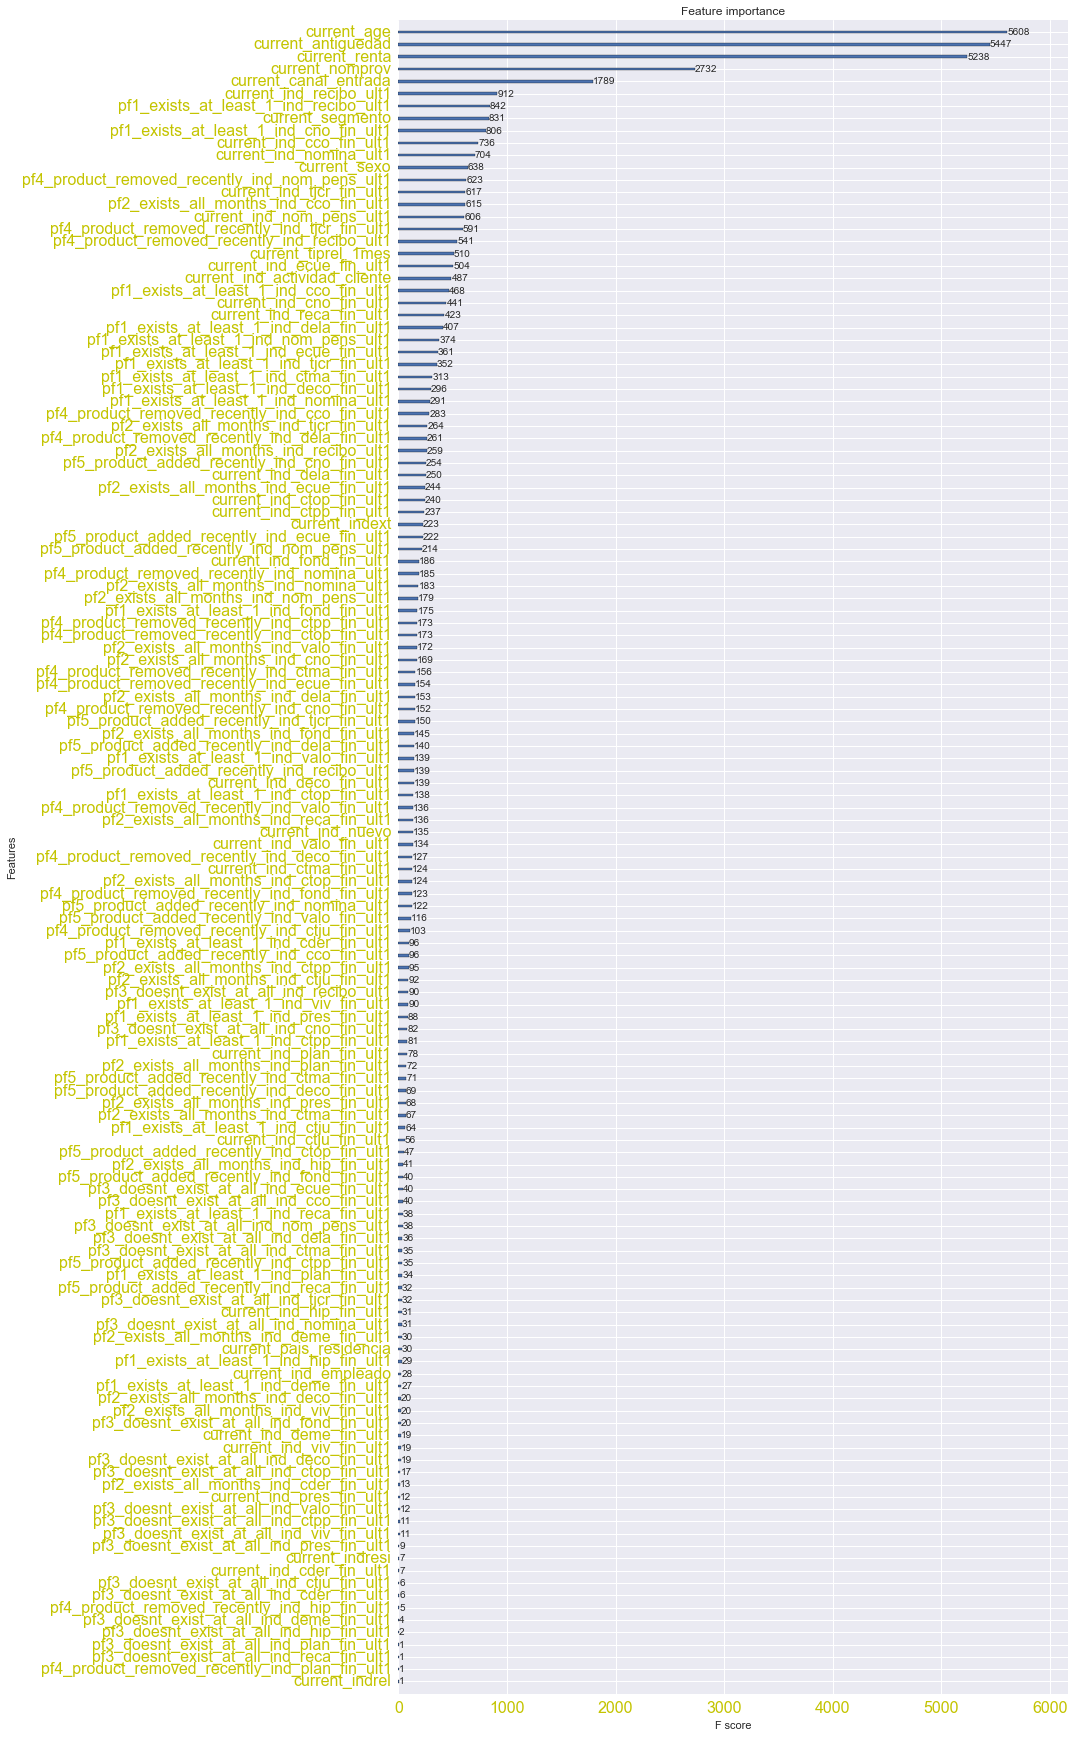

time: 4.55 s


In [119]:
pylab.rcParams['figure.figsize'] = (12, 30)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=16, labelcolor="#c4c400")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

In [115]:
pickle_description = '8. Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))

time: 34.7 s


In [107]:
orig_params = {'colsample_bytree': 0.6,
                'eta': 0.1,
                'gamma': 0.4,
                'max_delta_step': 7,
                'max_depth': 4,
                'min_child_weight': 1,
                'nthread': 4,
                'objective': 'multi:softprob',
                'scale_pos_weight': 0,
                'subsample': 0.75,
                'silent': 1
            }

tup = lambda t: list(itertools.izip(itertools.repeat(t[0]), t[1]))

def get_list_of_params(params_range):
    pr = list(map(tup, params_range.items()))
    pro = map(dict, list(itertools.product(*pr)))
    return pro


def grid_search_xgb(params_range_dict):
    grid_params_list = get_list_of_params(params_range_dict)
    p = Pool(2)
    maps = map(get_map_of_xgb, grid_params_list)
    p.close()
    p.join()
    sorted_maps = sorted(maps, cmp = lambda x, y: cmp(x['map'], y['map']), reverse = True)
    print "top map results", sorted_maps[:3]
    return sorted_maps

def get_map_of_xgb(grid_param):
    cv_params = dict(orig_params)
    num_class = {'num_class': len(label_encoder.classes_)}
    cv_params.update(num_class)
    cv_params.update(grid_param)
    # print orig_params, grid_param
    temp_cv = xgb.cv(cv_params, xgb_main, num_boost_round = 20, stratified=True,
             early_stopping_rounds = 20, feval = map7eval, maximize = True)
    temp_map = temp_cv['test-MAP@7-mean'][temp_cv.shape[0]-1]
    grid_param['map'] = temp_map
    # print "cv results", grid_param
    return grid_param

param_range1 = {
    'max_depth': range(2, 7, 2),
    'min_child_weight': range(1, 7, 2)
}
param_range2 = {
    'gamma': [i/10.0 for i in range(0, 6)],
    'colsample_bylevel': [i/10.0 for i in range(5, 10)]
}
param_range3 = {
    'max_delta_step': range(3, 10, 2)
}
param_range4 = {
    'subsample': [i/100.0 for i in range(80, 100, 5)],
    'colsample_bytree': [i/100.0 for i in range(80, 100, 5)]
}

21467

In [120]:
train.head()

,current_ind_empleado,current_pais_residencia,current_sexo,current_age,current_ind_nuevo,current_antiguedad,current_indrel,current_indrel_1mes,current_tiprel_1mes,current_indresi,...,pf1_exists_at_least_1_ind_nom_pens_ult1,pf2_exists_all_months_ind_nom_pens_ult1,pf3_doesnt_exist_at_all_ind_nom_pens_ult1,pf4_product_removed_recently_ind_nom_pens_ult1,pf5_product_added_recently_ind_nom_pens_ult1,pf1_exists_at_least_1_ind_recibo_ult1,pf2_exists_all_months_ind_recibo_ult1,pf3_doesnt_exist_at_all_ind_recibo_ult1,pf4_product_removed_recently_ind_recibo_ult1,pf5_product_added_recently_ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
15892,2,36,0,61,0.0,246.0,1.0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
15897,0,36,2,61,0.0,246.0,1.0,0,0,1,...,1,0,0,1,1,1,1,0,0,0
15906,3,36,0,55,0.0,227.0,1.0,0,0,1,...,1,0,0,1,1,1,1,0,0,0
15925,2,36,2,62,0.0,246.0,1.0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
15927,1,36,2,62,0.0,245.0,1.0,0,0,1,...,0,0,1,0,0,1,1,0,0,0


time: 318 ms


In [153]:
get_all_past_values_of_col(15892, train_old_1.columns[0], [train_old_1, train_old_2, train_old_3, train_old_4])

[2, 2, 2, 2]

time: 5.88 ms


In [136]:
list(enumerate(train_old_1.columns))

[(0, 'ind_empleado'),
 (1, 'pais_residencia'),
 (2, 'sexo'),
 (3, 'age'),
 (4, 'ind_nuevo'),
 (5, 'antiguedad'),
 (6, 'indrel'),
 (7, 'indrel_1mes'),
 (8, 'tiprel_1mes'),
 (9, 'indresi'),
 (10, 'indext'),
 (11, 'conyuemp'),
 (12, 'canal_entrada'),
 (13, 'indfall'),
 (14, 'nomprov'),
 (15, 'ind_actividad_cliente'),
 (16, 'renta'),
 (17, 'segmento'),
 (18, 'ind_ahor_fin_ult1'),
 (19, 'ind_aval_fin_ult1'),
 (20, 'ind_cco_fin_ult1'),
 (21, 'ind_cder_fin_ult1'),
 (22, 'ind_cno_fin_ult1'),
 (23, 'ind_ctju_fin_ult1'),
 (24, 'ind_ctma_fin_ult1'),
 (25, 'ind_ctop_fin_ult1'),
 (26, 'ind_ctpp_fin_ult1'),
 (27, 'ind_deco_fin_ult1'),
 (28, 'ind_deme_fin_ult1'),
 (29, 'ind_dela_fin_ult1'),
 (30, 'ind_ecue_fin_ult1'),
 (31, 'ind_fond_fin_ult1'),
 (32, 'ind_hip_fin_ult1'),
 (33, 'ind_plan_fin_ult1'),
 (34, 'ind_pres_fin_ult1'),
 (35, 'ind_reca_fin_ult1'),
 (36, 'ind_tjcr_fin_ult1'),
 (37, 'ind_valo_fin_ult1'),
 (38, 'ind_viv_fin_ult1'),
 (39, 'ind_nomina_ult1'),
 (40, 'ind_nom_pens_ult1'),
 (41, 'ind_

time: 8.18 ms


In [158]:
def is_col_changed_in_past(past_values):
    """
    products go from current month to older months
    """
    current = past_values[0]
    is_changed = False
    for v in past_values[1:]:
        is_changed = current != v
        current = v
        if is_changed:
            return is_changed
    return is_changed

time: 3.75 ms


In [164]:
is_col_changed_in_past([1,1,0,1])

True

time: 3.36 ms


In [169]:
changed = pd.DataFrame()
changed['ncodpers'] = test_new.index
changed.set_index('ncodpers', inplace=True)
for i in tqdm(test_new.index):
    for col in train_old_1.columns[:18]:
        past_values = get_all_past_values_of_col(i, col, [test_old_1, test_old_2, test_old_3, test_old_4])
        is_changed = is_col_changed_in_past(past_values)
        changed.set_value(i, 'is_changed_' + col, is_changed)
    

100%|██████████| 929615/929615 [15:11<00:00, 1020.04it/s]

time: 15min 11s


In [170]:
for col in changed.columns:
    print changed[col].value_counts()

False    929615
Name: is_changed_ind_empleado, dtype: int64
False    929576
True         39
Name: is_changed_pais_residencia, dtype: int64
False    929606
True          9
Name: is_changed_sexo, dtype: int64
False    685029
True     244586
Name: is_changed_age, dtype: int64
False    865799
True      63816
Name: is_changed_ind_nuevo, dtype: int64
True     925251
False      4364
Name: is_changed_antiguedad, dtype: int64
False    929529
True         86
Name: is_changed_indrel, dtype: int64
False    915490
True      14125
Name: is_changed_indrel_1mes, dtype: int64
False    894211
True      35404
Name: is_changed_tiprel_1mes, dtype: int64
False    929577
True         38
Name: is_changed_indresi, dtype: int64
False    929516
True         99
Name: is_changed_indext, dtype: int64
False    929563
True         52
Name: is_changed_conyuemp, dtype: int64
False    914083
True      15532
Name: is_changed_canal_entrada, dtype: int64
False    929470
True        145
Name: is_changed_indfall, dtype: int6

In [173]:
for col in test_old_1.columns:
    print col, get_all_past_values_of_col(1533309, col, [test_old_1, test_old_2, test_old_3, test_old_4])

ind_empleado [3, 3, 3, 3]
pais_residencia [36, 36, 36, 36]
sexo [0, 0, 0, 0]
age [52, 52, 52, 52]
ind_nuevo [1.0, 1.0, 1.0, 1.0]
antiguedad [3.0, 2.0, 1.0, 0.0]
indrel [1.0, 1.0, 1.0, 1.0]
indrel_1mes [0, 0, 0, 4]
tiprel_1mes [1, 0, 0, 0]
indresi [1, 1, 1, 1]
indext [0, 0, 0, 0]
conyuemp [2, 2, 2, 2]
canal_entrada [155, 155, 155, 162]
indfall [0, 0, 0, 0]
nomprov [14, 14, 14, 14]
ind_actividad_cliente [1.0, 1.0, 1.0, 0.0]
renta [95184.839999999997, 95184.839999999997, 95184.839999999997, 95184.839999999997]
segmento [1, 1, 1, 3]
ind_ahor_fin_ult1 [0, 0, 0, 0]
ind_aval_fin_ult1 [0, 0, 0, 0]
ind_cco_fin_ult1 [1, 1, 1, 0]
ind_cder_fin_ult1 [0, 0, 0, 0]
ind_cno_fin_ult1 [0, 0, 0, 0]
ind_ctju_fin_ult1 [0, 0, 0, 0]
ind_ctma_fin_ult1 [0, 0, 0, 0]
ind_ctop_fin_ult1 [0, 0, 0, 0]
ind_ctpp_fin_ult1 [0, 0, 0, 0]
ind_deco_fin_ult1 [0, 0, 0, 0]
ind_deme_fin_ult1 [0, 0, 0, 0]
ind_dela_fin_ult1 [0, 0, 0, 0]
ind_ecue_fin_ult1 [0, 0, 0, 0]
ind_fond_fin_ult1 [0, 0, 0, 0]
ind_hip_fin_ult1 [0, 0, 0, 0]
ind

In [171]:
changed.loc[changed.is_changed_segmento,:].head()

,is_changed_ind_empleado,is_changed_pais_residencia,is_changed_sexo,is_changed_age,is_changed_ind_nuevo,is_changed_antiguedad,is_changed_indrel,is_changed_indrel_1mes,is_changed_tiprel_1mes,is_changed_indresi,is_changed_indext,is_changed_conyuemp,is_changed_canal_entrada,is_changed_indfall,is_changed_nomprov,is_changed_ind_actividad_cliente,is_changed_renta,is_changed_segmento
ncodpers,,,,,,,,,,,,,,,,,,
1533309,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,True,False,True
1539700,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,True
1333325,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
1531232,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True
1239851,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,True


time: 747 ms


# Not just June 2015 data for training, include all the training samples

## This failed go to 9. Notebook

In [184]:
def get_file_string_from_train_data(train_data):
    date_time = datetime.datetime(train_data[0], train_data[1], 28)
    return '_'.join(str(date_time.date()).split('-'))

def get_date_string_from_train_data(train_data):
    date_time = datetime.datetime(train_data[0], train_data[1], 28)
    return '-'.join(str(date_time.date()).split('-'))

def subtract_one_month(train_data):
    if train_data[1] == 1:
        return 2015, 12
    else:
        return train_data[0], train_data[1] - 1
    
som = subtract_one_month

time: 31.6 ms


In [178]:
get_file_string_from_train_data(som(som((2015,6))))

'2015_04_28'

time: 3.22 ms


In [179]:
TRAIN_DATA = 2015, 7

TRAIN_MONTH_OLD_4 = get_file_string_from_train_data(som(som(som(som(TRAIN_DATA)))))
TRAIN_MONTH_OLD_3 = get_file_string_from_train_data(som(som(som(TRAIN_DATA))))
TRAIN_MONTH_OLD_2 = get_file_string_from_train_data(som(som(TRAIN_DATA)))
TRAIN_MONTH_OLD_1 = get_file_string_from_train_data(som(TRAIN_DATA))
TRAIN_MONTH_NEW = get_file_string_from_train_data(TRAIN_DATA)


TRAIN_FILE_OLD_4 = 'data/train_' + TRAIN_MONTH_OLD_4 + '.csv'
TRAIN_FILE_OLD_3 = 'data/train_' + TRAIN_MONTH_OLD_3 + '.csv'
TRAIN_FILE_OLD_2 = 'data/train_' + TRAIN_MONTH_OLD_2 + '.csv'
TRAIN_FILE_OLD_1 = 'data/train_' + TRAIN_MONTH_OLD_1 + '.csv'
TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD_1 + '.csv'


time: 14.3 ms


In [181]:
print TRAIN_FILE_NEW
print TRAIN_FILE_OLD_1
print TRAIN_FILE_OLD_2
print TRAIN_FILE_OLD_3
print TRAIN_FILE_OLD_4
print ADDED_PRODUCTS_FILE

data/train_2015_07_28.csv
data/train_2015_06_28.csv
data/train_2015_05_28.csv
data/train_2015_04_28.csv
data/train_2015_03_28.csv
data/added_product_2015_06_28.csv
time: 2.94 ms


In [182]:
train_old_4 = pd.read_csv(TRAIN_FILE_OLD_4, header=None, names=HEADER)
train_old_3 = pd.read_csv(TRAIN_FILE_OLD_3, header=None, names=HEADER)
train_old_2 = pd.read_csv(TRAIN_FILE_OLD_2, header=None, names=HEADER)
train_old_1 = pd.read_csv(TRAIN_FILE_OLD_1, header=None, names=HEADER)
train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)

added_products_temp = pd.read_csv(ADDED_PRODUCTS_FILE)

time: 28.6 s


In [183]:
combined = pd.concat((train_old_4, train_old_3, train_old_2, train_old_1,train_new)).reset_index(drop=True)
del train_old_4, train_old_3, train_old_2, train_old_1, train_new
gc.collect()

combined, encoders = process_data_from_original_dataframe(combined)

time: 2min 28s


In [188]:
train_old_4 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_4.split('_')), :].reset_index(drop=True)
train_old_3 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_3.split('_')), :].reset_index(drop=True)
train_old_2 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_2.split('_')), :].reset_index(drop=True)
train_old_1 = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_OLD_1.split('_')), :].reset_index(drop=True)
train_new = combined.loc[combined.fecha_dato == '-'.join(TRAIN_MONTH_NEW.split('_')), :].reset_index(drop=True)


time: 5.32 s


In [199]:
del train_old_1['index'], train_old_2['index'], train_old_3['index'], train_old_4['index'], train_new['index']
del train_old_1['fecha_dato'], train_old_2['fecha_dato'], train_old_3['fecha_dato'], train_old_4['fecha_dato'], train_new['fecha_dato']

time: 2.32 s


In [200]:
for df in train_old_1, train_old_2, train_old_3, train_old_4, train_new:
    print df.shape

(632110, 43)
(631957, 43)
(630367, 43)
(629209, 43)
(829817, 43)
time: 14.6 ms


In [201]:
train_new.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,723914,3,35,0,36,0.0,93.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1082373,3,35,0,32,0.0,33.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,965491,3,35,2,23,0.0,45.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1082287,3,35,2,23,0.0,33.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,218528,3,35,2,58,0.0,174.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0


time: 46.8 ms


In [209]:
train_old_4.set_index('ncodpers', inplace=True)
train_old_3.set_index('ncodpers', inplace=True)
train_old_2.set_index('ncodpers', inplace=True)
train_old_1.set_index('ncodpers', inplace=True)
train_new.set_index('ncodpers', inplace=True)

added_products_temp.set_index('ncodpers', inplace=True)

time: 2.46 s


In [203]:
added_products.head()

,added_product,encoded_products
ncodpers,,
15892,ind_cco_fin_ult1,0
15897,ind_nom_pens_ult1,13
15906,ind_nom_pens_ult1,13
15925,ind_recibo_ult1,18
15927,ind_cco_fin_ult1,0


time: 11.1 ms


In [210]:
train_temp = pd.DataFrame()
train_temp['ncodpers'] = added_products_temp.index
train_temp.set_index('ncodpers', inplace=True)


for col in train_new.columns[:18]:
    train_temp['current_' + col] = train_new.loc[added_products_temp.index, col]
    
for col in HEADER[24:]:
    train_temp['current_' + col] = train_old_1.loc[added_products_temp.index, col]

time: 7.38 s


In [211]:
train_temp.head()

,current_ind_empleado,current_pais_residencia,current_sexo,current_age,current_ind_nuevo,current_antiguedad,current_indrel,current_indrel_1mes,current_tiprel_1mes,current_indresi,...,current_ind_hip_fin_ult1,current_ind_plan_fin_ult1,current_ind_pres_fin_ult1,current_ind_reca_fin_ult1,current_ind_tjcr_fin_ult1,current_ind_valo_fin_ult1,current_ind_viv_fin_ult1,current_ind_nomina_ult1,current_ind_nom_pens_ult1,current_ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
15894,0,35,2,59,0.0,246.0,1.0,0,0,1,...,0,0,0,1,1,1,0,1,1,1
15901,2,35,2,55,0.0,246.0,1.0,0,0,1,...,0,0,0,0,1,1,0,0,0,1
15921,2,35,2,61,0.0,246.0,1.0,0,0,1,...,0,1,0,0,1,1,0,0,0,1
15924,1,35,2,52,0.0,246.0,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
15943,1,35,2,50,0.0,246.0,1.0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


time: 59.3 ms


In [208]:
train_new.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,723914,3,35,0,36,0.0,93.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1082373,3,35,0,32,0.0,33.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,965491,3,35,2,23,0.0,45.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1082287,3,35,2,23,0.0,33.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,218528,3,35,2,58,0.0,174.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0


time: 36.1 ms
